# TIDES Earthquake Data

Notebook to download and process the earthquake data for the TIDES practicals.

Please ignore the warnings. They are a consequence of me using the development version of ObsPy and not the latest stable version.

In the end there will be 4 folders:

* `events`: Event data as QuakeML and CMTSOLUTION files
* `stations`: StationXML files for all stations and a cumulative one; also contains a STATIONS file suitable as input for many waveform solvers.
* `waveforms`: Raw downloaded data
* `processed_data`: Velocity seismograms converted to `m/s` and filtered in various frequency bands. Please see the end of this documents for details about the applied processing.

## Step 1: Get the Data

In [1]:
%matplotlib inline
from __future__ import print_function

Some basic setup.

In [2]:
import os

event_folder = os.path.join("data", "events")
stations_folder = os.path.join("data", "stations")
quakeml_folder = os.path.join(event_folder, "quakeml")
waveform_folder = os.path.join("data", "waveforms")
processed_waveform_folder = os.path.join("data", "processed_waveforms")
if not os.path.exists(quakeml_folder):
    os.makedirs(quakeml_folder)
if not os.path.exists(stations_folder):
    os.makedirs(stations_folder)

#### Italian Events from the INGV

We will choose two local events with moment tensor solutions from the INGV.

* 2012-05-29T07:00:02.880000Z, Mw: 5.6 event in Northern Italy
* 2015-01-23T06:51:20.340000Z, Mw: 5.4 event in Bologna

In [3]:
import obspy
from obspy.fdsn import Client

client = Client("INGV")

event_time_1 = obspy.UTCDateTime(2012, 5, 29, 7, 0, 3)
event_time_2 = obspy.UTCDateTime(2015, 1, 23, 6, 51, 20)

client.get_events(starttime=event_time_1 - 60,
                  endtime=event_time_1 + 60,
                  filename=os.path.join(quakeml_folder, "INGV_2012_05_29__Mw_5_6.xml"))

client.get_events(starttime=event_time_2 - 60,
                  endtime=event_time_2 + 60,
                  filename=os.path.join(quakeml_folder, "INGV_2015_01_23__Mw_4_3.xml"))

/Users/lion/workspace/code/obspy/obspy/__init__.py:150: ObsPyDeprecationWarning: Module 'obspy.fdsn' is deprecated and will stop working with the next ObsPy version. Please import module 'obspy.clients.fdsn' instead.
  ObsPyDeprecationWarning)


/Users/lion/workspace/code/obspy/obspy/core/util/deprecation_helpers.py:55: ObsPyDeprecationWarning: Function 'obspy.readEvents' is deprecated and will stop working with the next ObsPy version. Please use 'obspy.read_events' instead.
  ObsPyDeprecationWarning)
/Users/lion/workspace/code/obspy/obspy/imaging/maps.py:51: UserWarning: Cartopy not installed.
  warnings.warn("Cartopy not installed.")


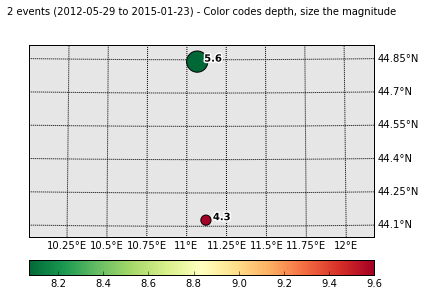

In [4]:
cat = obspy.readEvents(os.path.join(quakeml_folder, "INGV_2012_05_29__Mw_5_6.xml"))
cat += obspy.readEvents(os.path.join(quakeml_folder, "INGV_2015_01_23__Mw_4_3.xml"))
cat.plot(projection="local", resolution="i");

#### Teleseismic Events from the GCMT Catalog

We will furthermore chose four teleseismic events: The big Chile event from last year and one aftershock and the recent Nepal earthquake and its "aftershock" two weeks later.

* 2014-04-01 23:46:47, Mw: 8.1 event near Northern Coast of Chile: http://ds.iris.edu/spud/momenttensor/9647147
* 2014-04-04 01:37:50, Mw: 6.2 event near Northern Coast of Chile: http://ds.iris.edu/spud/momenttensor/9647207

* 2015-04-25 06:11:26, Mw: 7.9 in Nepal: http://ds.iris.edu/spud/momenttensor/9925741
* 2015-05-12 07:05:19, Mw: 7.2 in Nepal: http://ds.iris.edu/spud/momenttensor/9954411

## Step 2: Assert Equality of CMTSOLUTIONS and QuakeML files

Requires a very recent ObsPy version for the CMTSOLUTIONS support. Just to make sure we have no obvious errors.

In [5]:
!ls -l data/events/quakeml/
!ls -l data/events/cmtsolutions/

total 96
-rw-r--r--@ 1 lion  staff  8008 May  7 11:58 GCMT_2014_04_01__Mw_8_1.xml
-rw-r--r--@ 1 lion  staff  7961 May  7 11:59 GCMT_2014_04_04__Mw_6_2.xml
-rw-r--r--@ 1 lion  staff  7967 May 11 00:15 GCMT_2015_04_25__Mw_7_9.xml
-rw-r--r--@ 1 lion  staff  7956 May 14 01:10 GCMT_2015_05_12__Mw_7_2.xml
-rw-r--r--@ 1 lion  staff  6403 May 14 01:31 INGV_2012_05_29__Mw_5_6.xml
-rw-r--r--@ 1 lion  staff  6411 May 14 01:31 INGV_2015_01_23__Mw_4_3.xml
total 48
-rw-r--r--@ 1 lion  staff  380 May  7 11:58 GCMT_2014_04_01__Mw_8_1
-rw-r--r--@ 1 lion  staff  380 May  7 11:59 GCMT_2014_04_04__Mw_6_2
-rw-r--r--@ 1 lion  staff  361 May 11 00:15 GCMT_2015_04_25__Mw_7_9
-rw-r--r--@ 1 lion  staff  361 May 14 01:10 GCMT_2015_05_12__Mw_7_2
-rw-r--r--@ 1 lion  staff  425 May  7 12:10 INGV_2012_05_29__Mw_5_6
-rw-r--r--@ 1 lion  staff  425 May  7 12:11 INGV_2015_01_23__Mw_4_3


In [6]:
import glob
import obspy

for quakeml, cmt in zip(sorted(glob.glob("./data/events/quakeml/*Mw*")),
                        sorted(glob.glob("./data/events/cmtsolutions/*Mw*"))):
    print("=======")
    print(obspy.read_events(quakeml))
    print(obspy.read_events(cmt))

1 Event(s) in Catalog:
2014-04-01T23:47:31.500000Z | -19.700,  -70.810 | 8.1 Mwc
1 Event(s) in Catalog:
2014-04-01T23:47:31.499999Z | -19.700,  -70.810 | 8.12 mw
1 Event(s) in Catalog:
2014-04-04T01:37:57.900000Z | -20.610,  -70.910 | 6.2 Mwc
1 Event(s) in Catalog:
2014-04-04T01:37:57.900000Z | -20.610,  -70.910 | 6.23 mw
1 Event(s) in Catalog:
2015-04-25T06:11:58.400000Z | +27.770,  +85.370 | 7.9 Mwc
1 Event(s) in Catalog:
2015-04-25T06:11:58.399999Z | +27.770,  +85.370 | 7.86 mw
1 Event(s) in Catalog:
2015-05-12T07:05:28.500000Z | +27.560,  +86.100 | 7.2 Mwc
1 Event(s) in Catalog:
2015-05-12T07:05:28.500000Z | +27.560,  +86.100 | 7.24 mw
1 Event(s) in Catalog:
2012-05-29T07:00:02.880000Z | +44.842,  +11.066 | 5.6 Mw | manual
1 Event(s) in Catalog:
2012-05-29T07:00:02.879999Z | +44.842,  +11.066 | 5.63 mw
1 Event(s) in Catalog:
2015-01-23T06:51:20.340000Z | +44.127,  +11.121 | 4.3 Mw | manual
1 Event(s) in Catalog:
2015-01-23T06:51:20.339999Z | +44.127,  +11.121 | 4.26 mw


## Step 3: Station Data

We manually selected 9 stations, not all of them are active over the whole time span.

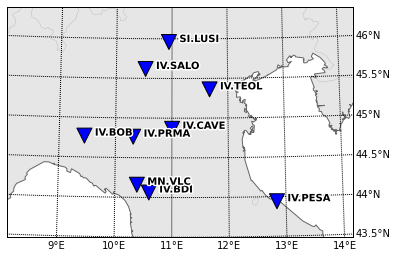

In [7]:
# Limit by earliest and latest events.
starttime = obspy.UTCDateTime(2011, 12, 1)
endtime = obspy.UTCDateTime(2015, 5, 1)
stations = [
    ("IV", "BDI", "", "BH?", starttime, endtime),
    ("IV", "BOB", "", "BH?", starttime, endtime),
    ("IV", "CAVE", "", "HH?", starttime, endtime),
    ("SI", "LUSI", "", "HH?", starttime, endtime),
    ("IV", "PESA", "", "BH?", starttime, endtime),
    ("IV", "PRMA", "", "HH?", starttime, endtime),
    ("IV", "SALO", "", "BH?", starttime, endtime),
    ("IV", "TEOL", "", "BH?", starttime, endtime),
    ("MN", "VLC", "", "HH?", starttime, endtime)]

# Get it all and plot it.
cat = client.get_stations_bulk(stations, level="channel")
cat.plot(projection="local", resolution="i");

In [8]:
# Now get it per station and store with full response information.
for network, station, location, channel, starttime, endtime in stations:
    client.get_stations(network=network, station=station, location=location,
                        channel=channel, starttime=starttime, endtime=endtime,
                        level="response",
                        filename=os.path.join(stations_folder, "%s_%s.xml" % (network, station)))
    
# Once more to have one file for all which is convenient to have.
cat = client.get_stations_bulk(stations, level="response",
                               filename=os.path.join(stations_folder, "all_stations.xml"))

In [9]:
# Reformat as the INGV service serves hard to read files. Requires xmllint.
files = !ls $stations_folder
for filename in files:
    if "xml" not in filename:
        continue
    filename = os.path.join(stations_folder, filename)
    !xmllint --format --recover $filename > temp.xml
    !mv temp.xml $filename

Generate STATIONS file for waveform solvers.

In [10]:
import obspy

station_list = []
inv = obspy.read_inventory(os.path.join(stations_folder, "all_stations.xml"))
for network in inv:
    for station in network:
        station_list.append((station.code, network.code, station.latitude, 
                             station.longitude, station.elevation, station[0].depth))

station_file = os.path.join(stations_folder, "STATIONS")
with open(station_file, "wt") as fh:
    for i in station_list:
        fh.write("%-4s %2s %8.5f %8.5f %6.2f %5.2f\n" % i)

with open(station_file, "rt") as fh:
    print(fh.read())

BDI  IV 44.06238 10.59698 830.00  0.00
BOB  IV 44.76792  9.44782 910.00  0.00
CAVE IV 44.86580 11.00310  18.00  2.00
PESA IV 43.94105 12.84018 221.00  0.00
PRMA IV 44.76374 10.31311  78.00  0.00
SALO IV 45.61830 10.52430 600.00  1.00
TEOL IV 45.36167 11.67389 370.00  0.00
VLC  MN 44.15940 10.38640 555.00  3.00
LUSI SI 45.95950 10.94360 860.00  0.00



## Step 4: Download Waveform Data

In [11]:
import numpy as np

events = glob.glob(os.path.join(quakeml_folder, "*.xml"))
for event in events:
    name = os.path.splitext(os.path.basename(event))[0]
    folder = os.path.join(waveform_folder, name)
    if not os.path.exists(folder):
        os.makedirs(folder)
    event = obspy.readEvents(event)[0]
    origin = event.preferred_origin()
    # Get 5 minutes before to 90 minutes after the event. The students can then
    # cut the data themselves.
    starttime = origin.time - 5 * 50
    endtime = origin.time + 90 * 60
    
    print(folder)
    
    for network, station, location, channel, _, _ in stations:
        filename = filename=os.path.join(folder, "%s_%s.mseed" % (network, station))
        try:
            client.get_waveforms(network=network, station=station,
                                 location=location, channel=channel,
                                 starttime=starttime, endtime=endtime,
                                 filename=filename)
        except Exception as e:
            print("Event %s, Station %s.%s: Failed to download due to: %s" % (name, network, station, str(e)))
            continue
        # Also save as SAC.
        st = obspy.read(filename)
        for tr in st:
            tr.data = np.require(tr.data, dtype=np.float32)
            tr.write(os.path.splitext(filename)[0] + "_" + tr.stats.channel[-1] + ".sac", format="SAC")
        print("Event %s, Station %s.%s: Success" % (name, network, station))

data/waveforms/GCMT_2014_04_01__Mw_8_1
Event GCMT_2014_04_01__Mw_8_1, Station IV.BDI: Success
Event GCMT_2014_04_01__Mw_8_1, Station IV.BOB: Success
Event GCMT_2014_04_01__Mw_8_1, Station IV.CAVE: Success
Event GCMT_2014_04_01__Mw_8_1, Station SI.LUSI: Success
Event GCMT_2014_04_01__Mw_8_1, Station IV.PESA: Success
Event GCMT_2014_04_01__Mw_8_1, Station IV.PRMA: Success
Event GCMT_2014_04_01__Mw_8_1, Station IV.SALO: Success
Event GCMT_2014_04_01__Mw_8_1, Station IV.TEOL: Failed to download due to: No data available for request.
Event GCMT_2014_04_01__Mw_8_1, Station MN.VLC: Success
data/waveforms/GCMT_2014_04_04__Mw_6_2
Event GCMT_2014_04_04__Mw_6_2, Station IV.BDI: Success
Event GCMT_2014_04_04__Mw_6_2, Station IV.BOB: Success
Event GCMT_2014_04_04__Mw_6_2, Station IV.CAVE: Success
Event GCMT_2014_04_04__Mw_6_2, Station SI.LUSI: Success
Event GCMT_2014_04_04__Mw_6_2, Station IV.PESA: Success
Event GCMT_2014_04_04__Mw_6_2, Station IV.PRMA: Success
Event GCMT_2014_04_04__Mw_6_2, Statio

/Users/lion/workspace/code/obspy/obspy/core/util/deprecation_helpers.py:55: ObsPyDeprecationWarning: Function 'obspy.readEvents' is deprecated and will stop working with the next ObsPy version. Please use 'obspy.read_events' instead.
  ObsPyDeprecationWarning)


## Step 5: Process Data

We will just process the data in a couple of period bands. All will be in `m/s` in the end.

In [12]:
import glob
import obspy
import numpy as np

period_bands = [
    (1.0, 30.0),
    (1.0, 50.0),
    (1.0, 200.0),
    (10.0, 50.0),
    (30.0, 100.0),
    (30.0, 200.)]

inv = obspy.read_inventory(os.path.join(stations_folder, "all_stations.xml"))

for min_period, max_period in period_bands:
    print("Processing for period band from %.1f s to %.1f s" % (min_period, max_period))
    for event in glob.glob(os.path.join(waveform_folder, "*Mw*")):
        output_folder = os.path.join(processed_waveform_folder,
                                     "%is_%is" % (int(min_period), int(max_period)),
                                     os.path.basename(event))
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        for filename in glob.glob(os.path.join(event, "*.mseed")):
            st = obspy.read(filename)
            # Filter by applying a cosine taper during the instrument
            # deconvolution. Very simple and does not require to set
            # a water level.
            f2 = 1.0 / max_period
            f3 = 1.0 / min_period
            f1 = 0.8 * f2
            f4 = 1.2 * f3
            pre_filt = (f1, f2, f3, f4)
            st.attach_response(inv)
            st.remove_response(output="VEL", pre_filt=pre_filt, zero_mean=True,
                               taper=True)
            # We applied a pretty sharp filter in the frequency domain so 
            # we can savely resample without an additional aliasing filter.
            s_r = st[0].stats.sampling_rate
            desired_sr = 10.0
            factor = int(round(s_r / desired_sr))
            if factor > 1:
                st.decimate(factor=factor, no_filter=True)
                
            # single precision is ok
            for tr in st:
                tr.data = np.require(tr.data, dtype=np.float32)
            
            filename = os.path.join(output_folder, os.path.basename(filename))
            st.write(filename, format="mseed")
            
            # Also save as SAC.
            for tr in st:
                tr.write(os.path.splitext(filename)[0] + "_" + tr.stats.channel[-1] + ".sac", format="SAC")

Processing for period band from 1.0 s to 30.0 s
Processing for period band from 1.0 s to 50.0 s
Processing for period band from 1.0 s to 200.0 s
Processing for period band from 10.0 s to 50.0 s
Processing for period band from 30.0 s to 100.0 s
Processing for period band from 30.0 s to 200.0 s


/Users/lion/workspace/code/obspy/obspy/io/mseed/core.py:728: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Teleseismic 1 - 30 seconds


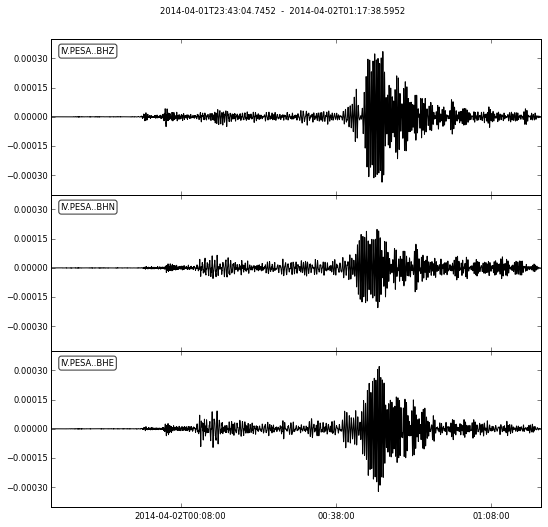

In [13]:
# Plot some examples
print("Teleseismic 1 - 30 seconds")
obspy.read("./data/processed_waveforms/1s_30s/GCMT_2014_04_01__Mw_8_1/IV_PESA.mseed").plot()

Teleseismic 30 - 100 seconds


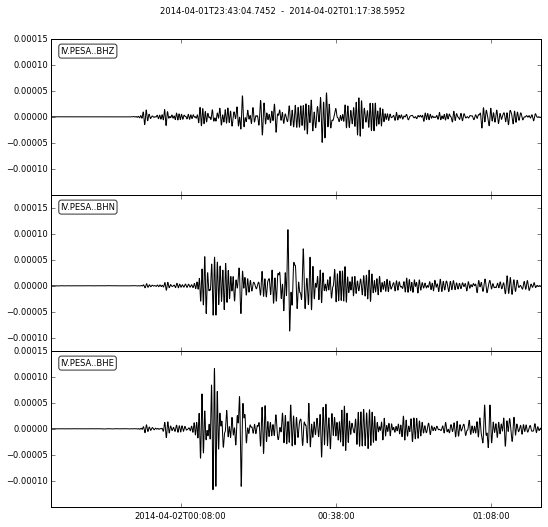

In [14]:
print("Teleseismic 30 - 100 seconds")
obspy.read("./data/processed_waveforms/30s_100s/GCMT_2014_04_01__Mw_8_1/IV_PESA.mseed").plot()

Local 1 - 30 seconds


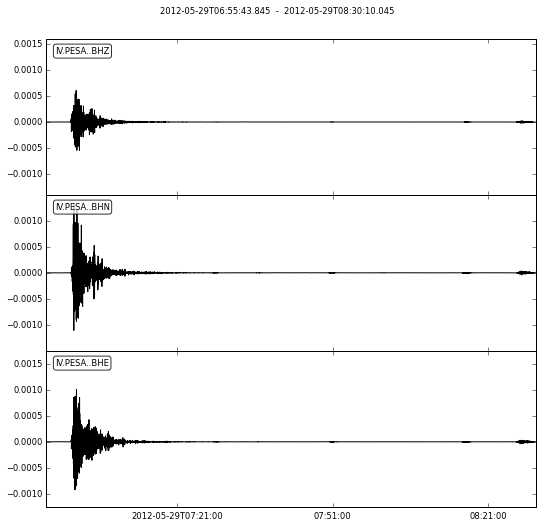

In [15]:
print("Local 1 - 30 seconds")
obspy.read("./data/processed_waveforms/1s_30s/INGV_2012_05_29__Mw_5_6/IV_PESA.mseed").plot()

Local 30 - 100 seconds


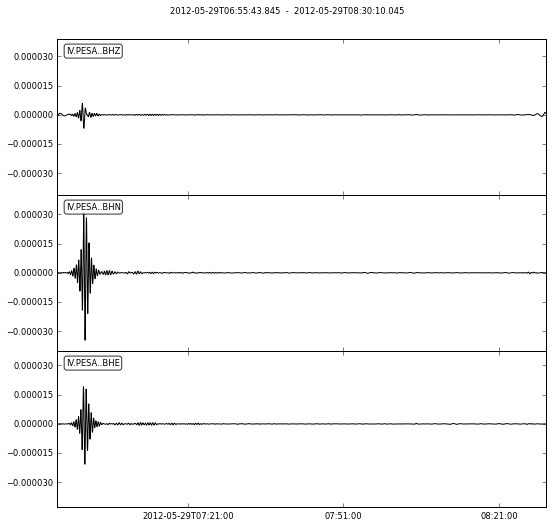

In [16]:
print("Local 30 - 100 seconds")
obspy.read("./data/processed_waveforms/30s_100s/INGV_2012_05_29__Mw_5_6/IV_PESA.mseed").plot()